# ARMAX MIMO Example

Example ARMAX MIMO case with 3 outputs and 4 inputs.

In [1]:
# Checking path to access other files
import numpy as np
from utils import plot_comparison

from sippy_unipi import system_identification
from sippy_unipi.datasets import load_sample_mimo
from sippy_unipi.evaluate import validation

seed = 0
np.random.seed(seed)

In [2]:
n_samples = 401
ts = 1.0
time, Ysim, Usim, g_sys, Yerr, Uerr, h_sys, Ytot, Utot = load_sample_mimo(
    n_samples, ts, seed=seed
)

/opt/pysetup/.venv/lib/python3.12/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


### Identification Parameters

In [3]:
na = [3, 1, 2]
nb = [[2, 1, 3, 2], [3, 2, 1, 1], [1, 2, 1, 2]]
th = [[1, 2, 2, 1], [1, 2, 0, 0], [0, 1, 0, 2]]
nc = [2, 2, 3]

ordersna = na
ordersnb = nb
ordersnc = nc
theta_list = th

# IDENTIFICATION STAGE
# TESTING ARMAX models
orders = [ordersna, ordersnb, ordersnc, theta_list]
identification_params = {
    "ARMAX-I": {
        "id_mode": "ILLS",
        "max_iter": 20,
        "centering": "MeanVal",
    },
    "ARMAX-O": {
        "id_mode": "OPT",
        "max_iter": 20,
        "centering": "MeanVal",
    },
    "ARMAX-R": {
        "id_mode": "RLLS",
        "max_iter": 20,
        "centering": "MeanVal",
    },
}

In [4]:
syss = []
for method, params in identification_params.items():
    sys_id = system_identification(Ytot, Usim, "ARMAX", *orders, **params)
    syss.append(sys_id)

Youts = [getattr(sys, "y_id") for sys in syss]

### Plot Identification Results

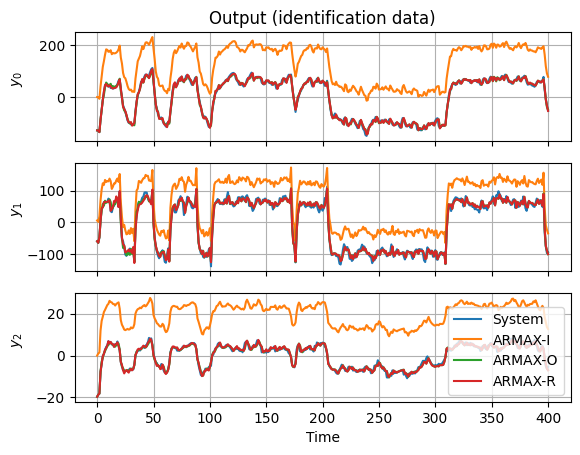

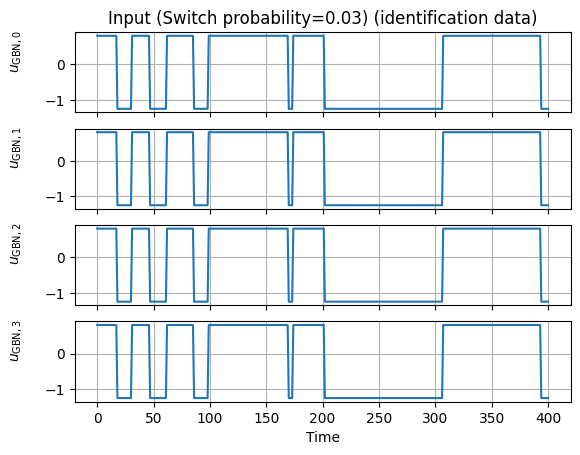

In [5]:
fig = plot_comparison(
    time,
    [Ytot] + Youts,
    ylabels=[f"$y_{i}$" for i in range(3)],
    legend=["System", "ARMAX-I", "ARMAX-O", "ARMAX-R"],
    title="Output (identification data)",
)

fig = plot_comparison(
    time,
    Usim,
    [r"$u_\mathrm{GBN, " + str(i) + "}$" for i in range(Usim.shape[1])],
    title="Input (Switch probability=0.03) (identification data)",
)

### Validation Stage

In [6]:
time, Ysim, Usim_v, g_sys, Yerr, Uerr, h_sys, Ytot_v, Utot_v = (
    load_sample_mimo(
        n_samples,
        ts,
        input_ranges=[(0.33, 0.7), (-2.0, -1.0), (1.3, 2.7), (1.0, 5.2)],
        seed=seed,
    )
)

# ## Compute time responses for identified systems with new inputs
Yv_armaxi = validation(syss[0], Usim_v, Ytot_v, time, centering="MeanVal")
Yv_armaxo = validation(syss[1], Usim_v, Ytot_v, time)
Yv_armaxr = validation(syss[2], Usim_v, Ytot_v, time, centering="InitVal")

### Plot Validation Results

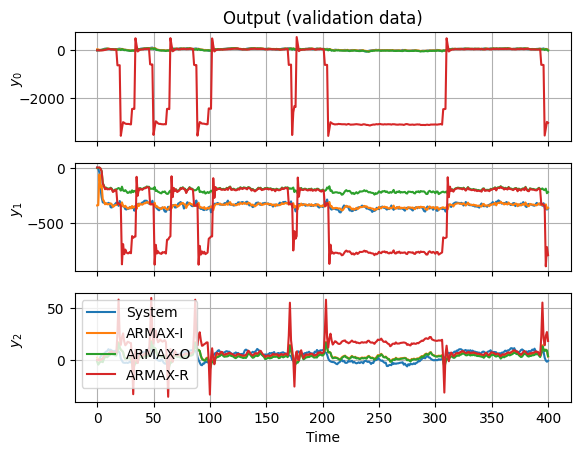

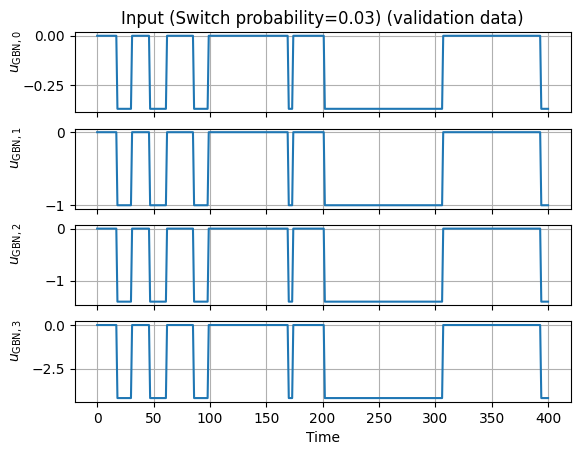

In [7]:
fig = plot_comparison(
    time,
    [Ytot_v, Yv_armaxi, Yv_armaxo, Yv_armaxr],
    ylabels=[f"$y_{i}$" for i in range(Ytot_v.shape[1])],
    legend=["System", "ARMAX-I", "ARMAX-O", "ARMAX-R"],
    title="Output (validation data)",
)

fig = plot_comparison(
    time,
    Usim_v,
    [r"$u_\mathrm{GBN, " + str(i) + "}$" for i in range(Usim_v.shape[1])],
    title="Input (Switch probability=0.03) (validation data)",
)